In [92]:
import os
import numpy as np
import pandas as pd
from ezdxf import readfile
from shapely.geometry import Polygon, LineString, MultiPolygon, box, Point
from shapely.affinity import translate, rotate
from catboost import CatBoostRegressor
import pickle
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import random

##### извлекаю данные о гроанице участка из dxf в numpy

In [93]:
dxf_folder = './DB_TEST/dxf'
output_folder = './DB_TEST/numpy'
os.makedirs(output_folder, exist_ok=True)
dxf_files = [f for f in os.listdir(dxf_folder) if f.lower().endswith('.dxf')]

if not dxf_files:
    print("No DXF files found in the specified folder.")
else:
    print(f"Found {len(dxf_files)} DXF files")

    for dxf_file in dxf_files:
        file_path = os.path.join(dxf_folder, dxf_file)
        print(f"\nProcessing: {dxf_file}")
        
        try:
            doc = readfile(file_path)
            lwpolylines = [e for e in doc.entities if e.dxftype() == 'LWPOLYLINE']
            
            if not lwpolylines:
                print("No LWPOLYLINE entities found in this file")
                continue
            
    
            all_vertices = []
            
            for i, polyline in enumerate(lwpolylines, 1):
                points = list(polyline.get_points())
                vertices = np.array([(x, y, *z) if z else (x, y, 0.0) for x, y, *z in points])
                all_vertices.append(vertices)
                
                print(f"LWPOLYLINE {i}: {len(vertices)} vertices")
            
    
            if all_vertices:
                combined_vertices = np.vstack(all_vertices)
                
        
                output_filename = os.path.splitext(dxf_file)[0] + '.npy'
                output_path = os.path.join(output_folder, output_filename)
                
                np.save(output_path, combined_vertices)
                print(f"Saved {len(combined_vertices)} vertices to {output_path}")
            
        except Exception as e:
            print(f"Error processing {dxf_file}: {str(e)}")

Found 30 DXF files

Processing: land_plot_1.dxf
LWPOLYLINE 1: 9 vertices
Saved 9 vertices to ./DB_TEST/numpy/land_plot_1.npy

Processing: land_plot_10.dxf
LWPOLYLINE 1: 7 vertices
Saved 7 vertices to ./DB_TEST/numpy/land_plot_10.npy

Processing: land_plot_11.dxf
LWPOLYLINE 1: 5 vertices
Saved 5 vertices to ./DB_TEST/numpy/land_plot_11.npy

Processing: land_plot_12.dxf
LWPOLYLINE 1: 7 vertices
Saved 7 vertices to ./DB_TEST/numpy/land_plot_12.npy

Processing: land_plot_13.dxf
LWPOLYLINE 1: 9 vertices
Saved 9 vertices to ./DB_TEST/numpy/land_plot_13.npy

Processing: land_plot_14.dxf
LWPOLYLINE 1: 8 vertices
Saved 8 vertices to ./DB_TEST/numpy/land_plot_14.npy

Processing: land_plot_15.dxf
LWPOLYLINE 1: 9 vertices
Saved 9 vertices to ./DB_TEST/numpy/land_plot_15.npy

Processing: land_plot_16.dxf
LWPOLYLINE 1: 6 vertices
Saved 6 vertices to ./DB_TEST/numpy/land_plot_16.npy

Processing: land_plot_17.dxf
LWPOLYLINE 1: 8 vertices
Saved 8 vertices to ./DB_TEST/numpy/land_plot_17.npy

Processing

##### посмотреть содержимое файлов numpy

In [94]:
directory = './DB_TEST/numpy'
npy_files = [f for f in os.listdir(directory) if f.endswith('.npy')]
data_numpy = []

for file in npy_files:
    filepath = os.path.join(directory, file)
    data = np.load(filepath, allow_pickle=True)
    

    if data.shape[-1] >= 3:
        trimmed_data = data[..., :-3]
    else:
        trimmed_data = data
    
    print(f"--- {file} ---")
    print("Original shape:", data.shape)
    print("Trimmed shape:", trimmed_data.shape if 'trimmed_data' in locals() else data.shape)
    print(trimmed_data if 'trimmed_data' in locals() else data)
    print()
    data_numpy.append(trimmed_data)
    # Optional: Save the trimmed data back to file
    np.save(filepath, trimmed_data)

--- land_plot_1.npy ---
Original shape: (9, 5)
Trimmed shape: (9, 2)
[[ 2. 23.]
 [ 5.  9.]
 [10.  6.]
 [19. 13.]
 [23.  7.]
 [72.  7.]
 [79. 66.]
 [10. 75.]
 [ 2. 23.]]

--- land_plot_10.npy ---
Original shape: (7, 5)
Trimmed shape: (7, 2)
[[ 7. 18.]
 [15.  0.]
 [80. 11.]
 [73. 62.]
 [57. 52.]
 [14. 57.]
 [ 7. 18.]]

--- land_plot_11.npy ---
Original shape: (5, 5)
Trimmed shape: (5, 2)
[[ 5.  2.]
 [78. 21.]
 [20. 78.]
 [ 7. 75.]
 [ 5.  2.]]

--- land_plot_12.npy ---
Original shape: (7, 5)
Trimmed shape: (7, 2)
[[14. 20.]
 [10. 14.]
 [21.  4.]
 [71. 20.]
 [64. 57.]
 [17. 80.]
 [14. 20.]]

--- land_plot_13.npy ---
Original shape: (9, 5)
Trimmed shape: (9, 2)
[[16.  8.]
 [24. 12.]
 [76. 21.]
 [79. 20.]
 [72. 64.]
 [22. 80.]
 [ 7. 78.]
 [16. 62.]
 [16.  8.]]

--- land_plot_14.npy ---
Original shape: (8, 5)
Trimmed shape: (8, 2)
[[ 6. 26.]
 [ 9. 12.]
 [60. 20.]
 [74. 24.]
 [57. 78.]
 [ 9. 70.]
 [11. 66.]
 [ 6. 26.]]

--- land_plot_15.npy ---
Original shape: (9, 5)
Trimmed shape: (9, 2)
[[10

##### посчитать площадь и добавить в dataframe

In [95]:
directory = './DB_TEST/numpy'
npy_files = [f for f in os.listdir(directory) if f.endswith('.npy')]

df = pd.DataFrame(columns=['filename', 'polygon_index', 'area', 'num_vertices'])

for file in npy_files:
    filepath = os.path.join(directory, file)
    data = np.load(filepath, allow_pickle=True)
    
    if data.ndim == 2:
        polygons = [data]
    elif data.ndim == 3:
        polygons = data
    else:
        print(f"Skipping {file} - unexpected array shape {data.shape}")
        continue
    
    for i, polygon in enumerate(polygons):
        try:
            polygon = np.atleast_2d(polygon)
            
            polygon = polygon[np.isfinite(polygon).all(axis=1)]
            
            if len(polygon) >= 3:
                if not np.array_equal(polygon[0], polygon[-1]):
                    polygon = np.vstack([polygon, polygon[0]])
                
                poly_obj = Polygon(polygon)
                
                if not poly_obj.is_valid:
                    poly_obj = poly_obj.buffer(0)

                area = poly_obj.area
                

                df = pd.concat([
                    df, 
                    pd.DataFrame([{
                        'filename': file,
                        'polygon_index': i,
                        'area': area,
                        'num_vertices': len(polygon)
                    }])
                ], ignore_index=True)
            else:
                print(f"Skipping polygon {i} in {file} - only {len(polygon)} points")
                
        except Exception as e:
            print(f"Error processing polygon {i} in {file}: {str(e)}")
            continue

print("\nPolygon Areas Summary:")
print(f"Total polygons processed: {len(df)}")
print(f"Average area: {df['area'].mean():.2f}")
print("\nFirst 30 polygons:")
print(df.head(30))


Polygon Areas Summary:
Total polygons processed: 30
Average area: 3543.73

First 30 polygons:
            filename polygon_index    area num_vertices
0    land_plot_1.npy             0  4447.0            9
1   land_plot_10.npy             0  3344.0            7
2   land_plot_11.npy             0  3103.0            5
3   land_plot_12.npy             0  3008.0            7
4   land_plot_13.npy             0  3449.5            9
5   land_plot_14.npy             0  3332.0            8
6   land_plot_15.npy             0  3002.0            9
7   land_plot_16.npy             0  3070.5            6
8   land_plot_17.npy             0  3872.5            8
9   land_plot_18.npy             0  4831.5            9
10  land_plot_19.npy             0  3067.0            8
11   land_plot_2.npy             0  3447.0            9
12  land_plot_20.npy             0  3921.0            7
13  land_plot_21.npy             0  3978.0            8
14  land_plot_22.npy             0  3702.5            9
15  land_

/tmp/ipykernel_4111/341497347.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([


In [96]:
df.columns

Index(['filename', 'polygon_index', 'area', 'num_vertices'], dtype='object')

In [97]:
# задаю INDEX файла dxf из папки ./DB_TEST/dxf
index_dxf = 5

##### генерация тестового dataframe на основе площади участка и таблиц с данными

In [98]:
polygon_area = df['area'][index_dxf]
buildings = {
    '(26, 18)': 468,
    '(18, 18)': 324,
    '(26, 16)': 416,
    '(26, 34)': 884,
    '(28, 16)': 448,
    '(44, 18)': 792,
    '(54, 16)': 864,
    'L-26x18+18x18': 792,
    'L-28x16+18x18': 772,
    'L-26x16+18x18': 740,
    'L-26x16+18x26': 884,
    'L-26x18+16x26': 884,
    'L-26x16+16x28': 864,
}

max_density_table = {
    3: 10.0,
    4: 11.8,
    5: 13.3,
    6: 14.5,
    7: 15.5,
    8: 16.4,
    9: 17.1,
    10: 17.8,
    11: 18.3,
    12: 18.8,
    13: 19.2,
    14: 19.6,
    15: 20.0,
    16: 20.3,
    17: 20.6,
    18: 20.9,
    19: 21.1,
    20: 21.3,
    21: 21.5,
    22: 21.7,
    23: 21.9,
    24: 22.1,
    25: 22.2
}

setback_rules = {
    (2, 4): 8,
    (5, 8): 8,
    (9, 25): 12
}

data = []

for floor in range(3, 26):
    setback = None
    for (min_floor, max_floor), setback_value in setback_rules.items():
        if min_floor <= floor <= max_floor:
            setback = setback_value
            break
    max_density = max_density_table[floor]
    max_living_area = polygon_area * (max_density / 10)
    max_footprint_area = max_living_area / (floor * 0.7)
    for building_type, footprint_area in buildings.items():
        data.append({
            'polygon_area': polygon_area,
            'floors': floor,
            'building_type': building_type,
            'setback': setback,
            'footprint_area': footprint_area,
            'max_living_area': max_living_area,
            'max_footprint_area': max_footprint_area
        })
df = pd.DataFrame(data)
print(df.head())

   polygon_area  floors building_type  setback  footprint_area  \
0        3332.0       3      (26, 18)        8             468   
1        3332.0       3      (18, 18)        8             324   
2        3332.0       3      (26, 16)        8             416   
3        3332.0       3      (26, 34)        8             884   
4        3332.0       3      (28, 16)        8             448   

   max_living_area  max_footprint_area  
0           3332.0         1586.666667  
1           3332.0         1586.666667  
2           3332.0         1586.666667  
3           3332.0         1586.666667  
4           3332.0         1586.666667  


In [99]:
# df.shape
# df.columns

In [100]:
df.sample(5)

,polygon_area,floors,building_type,setback,footprint_area,max_living_area,max_footprint_area
232,3332.0,20,L-26x18+16x26,12,884,7097.16,506.940000
160,3332.0,15,"(28, 16)",12,448,6664.00,634.666667
200,3332.0,18,"(44, 18)",12,792,6963.88,552.688889
168,3332.0,15,L-26x16+16x28,12,864,6664.00,634.666667
239,3332.0,21,"(44, 18)",12,792,7163.80,487.333333


##### загрузка модели и предсказание жилой площади

In [101]:
def load_model_and_encoder(model_path, encoder_path):
    """Load the saved model and one-hot encoder"""
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    
    with open(encoder_path, 'rb') as f:
        encoder = pickle.load(f)
    
    return model, encoder

def preprocess_new_data(new_data, encoder, categorical_cols, numerical_cols):
    """Preprocess new data using the saved one-hot encoder"""
    # Apply one-hot encoding to categorical features
    new_encoded = encoder.transform(new_data[categorical_cols])
    encoded_cols = encoder.get_feature_names_out(categorical_cols)
    
    # Create DataFrame with encoded features
    new_encoded_df = pd.DataFrame(new_encoded, columns=encoded_cols, index=new_data.index)
    
    # Combine with numerical features
    processed_data = pd.concat([new_data[numerical_cols], new_encoded_df], axis=1)
    
    return processed_data

if __name__ == "__main__":
    MODEL_PATH = './model/catboost_model.pkl'
    ENCODER_PATH = './model/onehot_encoder.pkl'
    model, encoder = load_model_and_encoder(MODEL_PATH, ENCODER_PATH)
    
    categorical_cols = ['building_type']
    numerical_cols = ['polygon_area', 'floors', 'setback', 'footprint_area',
       'max_living_area', 'max_footprint_area']
    
    processed_data = preprocess_new_data(df, encoder, categorical_cols, numerical_cols)

    predictions = model.predict(processed_data)
    
    df['predicted_living_area'] = predictions

##### сортируем результаты предсказаний по предсказанной площади

In [102]:
final_data = df

In [103]:
final_data['living_area'] = final_data['footprint_area'] * final_data['floors']

In [104]:
final_data = final_data[final_data['living_area'] < final_data['max_living_area']]

In [ ]:
final_data = final_data[(final_data['predicted_living_area'] < final_data['max_living_area']) & (final_data['max_living_area'] - final_data['predicted_living_area'] < 500)].sort_values(['predicted_living_area'], ascending=False).head(10)

In [106]:
final_data

,polygon_area,floors,building_type,setback,footprint_area,max_living_area,max_footprint_area,predicted_living_area,living_area
248,3332.0,22,"(18, 18)",12,324,7230.44,469.509091,7158.082176,7128
235,3332.0,21,"(18, 18)",12,324,7163.80,487.333333,6804.358532,6804
171,3332.0,16,"(26, 16)",12,416,6763.96,603.925000,6632.932005,6656
158,3332.0,15,"(26, 16)",12,416,6664.00,634.666667,6295.676253,6240
147,3332.0,14,"(28, 16)",12,448,6530.72,666.400000,6282.948953,6272
130,3332.0,13,"(26, 18)",12,468,6397.44,703.015385,6037.686562,6084
44,3332.0,6,"(44, 18)",8,792,4831.40,1150.333333,4801.543070,4752
47,3332.0,6,L-28x16+18x18,8,772,4831.40,1150.333333,4630.642005,4632
48,3332.0,6,L-26x16+18x18,8,740,4831.40,1150.333333,4510.881205,4440
36,3332.0,5,L-26x16+18x26,8,884,4431.56,1266.160000,4394.308618,4420


In [107]:
# buildings = {
#     '(26, 18)': 468,
#     '(18, 18)': 324,
#     '(26, 16)': 416,
#     '(26, 34)': 884,
#     '(28, 16)': 448,
#     '(44, 18)': 792,
#     '(54, 16)': 864,
#     'L-26x18+18x18': 792,
#     'L-28x16+18x18': 772,
#     'L-26x16+18x18': 740,
#     'L-26x16+18x26': 884,
#     'L-26x18+16x26': 884,
#     'L-26x16+16x28': 864,
# }

In [108]:
# building_blocks = ['(26, 18)',
# '(18, 18)',
# '(26, 16)',
# '(28, 16)']

In [109]:
building_types = [
    '(26, 18)',
    '(18, 18)',
    '(26, 16)',
    '(26, 34)',
    '(28, 16)',
    '(44, 18)',
    '(54, 16)',
    'L-26x18+18x18',
    'L-28x16+18x18',
    'L-26x16+18x18',
    'L-26x16+18x26',
    'L-26x18+16x26',
    'L-26x16+16x28',
]


In [110]:
def visualization(polygon_coords, setback, building_type, counter):
    polygon = Polygon(polygon_coords)
    inner_polygon = polygon.buffer(-setback, join_style=2)

    def create_building(b_type, position=(0, 0), rotation=0):
        if 'L' in b_type:
            parts = b_type.split('+')
            part1 = parts[0].split('x')
            w1 = int(part1[0].split('-')[1])
            h1 = int(part1[1])
            part2 = parts[1].split('x')
            w2 = int(part2[0])
            h2 = int(part2[1])
            
            building = Polygon([
                (0, 0), (w1, 0), (w1, h1), 
                (w2, h1), (w2, h1+h2), (0, h1+h2), (0, 0)
            ])
        else:
            dims = b_type.strip('()').split(',')
            w = int(dims[0])
            h = int(dims[1])
            building = box(0, 0, w, h)
        
        building = translate(building, position[0], position[1])
        if rotation != 0:
            building = rotate(building, rotation, origin=(position[0], position[1]))
        
        return building

    def find_valid_position(building_shape, container):
        min_x, min_y, max_x, max_y = container.bounds
        attempts = 300
        
        for _ in range(attempts):
            x = random.uniform(min_x, max_x - building_shape.bounds[2])
            y = random.uniform(min_y, max_y - building_shape.bounds[3])
            rotation = random.choice(list(range(0, 361, 1)))
            
            test_building = create_building(building_type, (x, y), rotation)
            
            if container.contains(test_building):
                return test_building, rotation  # Возвращаем и здание, и угол поворота
        
        return None, 0  # Возвращаем None и угол 0, если не удалось разместить

    building = None
    rotation = 0  # Инициализируем переменную rotation
    
    if not inner_polygon.is_empty:
        if isinstance(inner_polygon, MultiPolygon):
            container = max(inner_polygon.geoms, key=lambda p: p.area)
        else:
            container = inner_polygon
        
        building, rotation = find_valid_position(create_building(building_type), container)

    # Создаем изображение только если здание было размещено
    if building is not None:
        fig, ax = plt.subplots(figsize=(8, 8), facecolor='black')
        ax.set_facecolor('black')
        ax.set_xlim(0, 80)
        ax.set_ylim(0, 80)

        original_poly = plt.Polygon(polygon_coords, closed=True, fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(original_poly)

        if not inner_polygon.is_empty:
            if inner_polygon.geom_type == 'Polygon':
                inner_coords = np.array(inner_polygon.exterior.coords)
                inner_poly = plt.Polygon(inner_coords, closed=True, fill=False, edgecolor='#00BFFF', linewidth=1)
                ax.add_patch(inner_poly)
            elif inner_polygon.geom_type == 'MultiPolygon':
                for poly in inner_polygon.geoms:
                    inner_coords = np.array(poly.exterior.coords)
                    inner_poly = plt.Polygon(inner_coords, closed=True, fill=False, edgecolor='#00BFFF', linewidth=1)
                    ax.add_patch(inner_poly)

        building_coords = np.array(building.exterior.coords)
        building_poly = plt.Polygon(building_coords, closed=True, fill=True, edgecolor='yellow', facecolor='black', linewidth=1, alpha=0.7)
        ax.add_patch(building_poly)
        print(building_type)

        # Добавляем линию разделения для прямоугольных зданий
        if building_type in ['(26, 34)', '(44, 18)', '(54, 16)']:
            print(building_type, 'INSIDE IF')
            # Получаем размеры здания
            dims = building_type.strip('()').split(',')
            w = int(dims[0])
            h = int(dims[1])
            print(w, h)
            # Определяем параметры линии в зависимости от типа здания
            if building_type == '(26, 34)':
                # Линия параллельна малой стороне (26) на расстоянии 18
                line_coords_1 = [(-26, 18), (0, 18)]
            elif building_type == '(44, 18)':
                # Линия параллельна малой стороне (18) на расстоянии 26
                line_coords_1 = [(-18, 0), (-18, 18)]
            elif building_type == '(54, 16)':
                # Линия параллельна малой стороне (16) на расстоянии 28
                line_coords_1 = [(-26, 0), (-26, 16)]
            # print(line_coords_1)
            # Создаем линию и применяем те же преобразования, что и к зданию
            line_1 = LineString(line_coords_1)
            line_1 = translate(line_1, building_coords[0][0], building_coords[0][1])
            if rotation != 0:
                line_1 = rotate(line_1, rotation, origin=(building_coords[0][0], building_coords[0][1]))

            # Рисуем линию
            x, y = line_1.xy
            ax.plot(x, y, color='yellow', linewidth=1, alpha=0.7)

        
        # Добавляем линию разделения для L-образных зданий
        if 'L' in building_type:
            parts = building_type.split('+')
            part1 = parts[0].split('x')
            part2 = parts[1].split('x')
            w1 = int(part1[0].split('-')[1])
            h1 = int(part1[1])
            w2 = int(part2[0])
            h2 = int(part2[1])
            
            # Определяем базовые координаты линии (до поворота)
            if w1 > w2:  # Горизонтальное разделение (основная часть сверху)
                line_coords = [(0, h1), (w2, h1)]
            
            # Создаем линию и применяем те же преобразования, что и к зданию
            line = LineString(line_coords)
            line = translate(line, building_coords[0][0], building_coords[0][1])
            if rotation != 0:
                line = rotate(line, rotation, origin=(building_coords[0][0], building_coords[0][1]))

            # Рисуем линию
            x, y = line.xy
            ax.plot(x, y, color='yellow', linewidth=1, alpha=0.7 )

        ax.axis('off')
        plt.tight_layout()

        os.makedirs('./DB_TEST/png', exist_ok=True)
        plt.savefig(f'./DB_TEST/png/ready_plan_{counter}.png', bbox_inches='tight', pad_inches=0, dpi=100)
        plt.show()
        plt.close()

        print(f"Изображение успешно сохранено в ./DB_TEST/png/ready_plan_{counter}.png")
    else:
        print("Не удалось разместить здание заданного размера в зоне отступа - изображение не создано")

In [111]:
polygon_coords = data_numpy[index_dxf]

In [112]:
setbacks = list(final_data['setback'])
building_types = list(final_data['building_type'])

(18, 18)


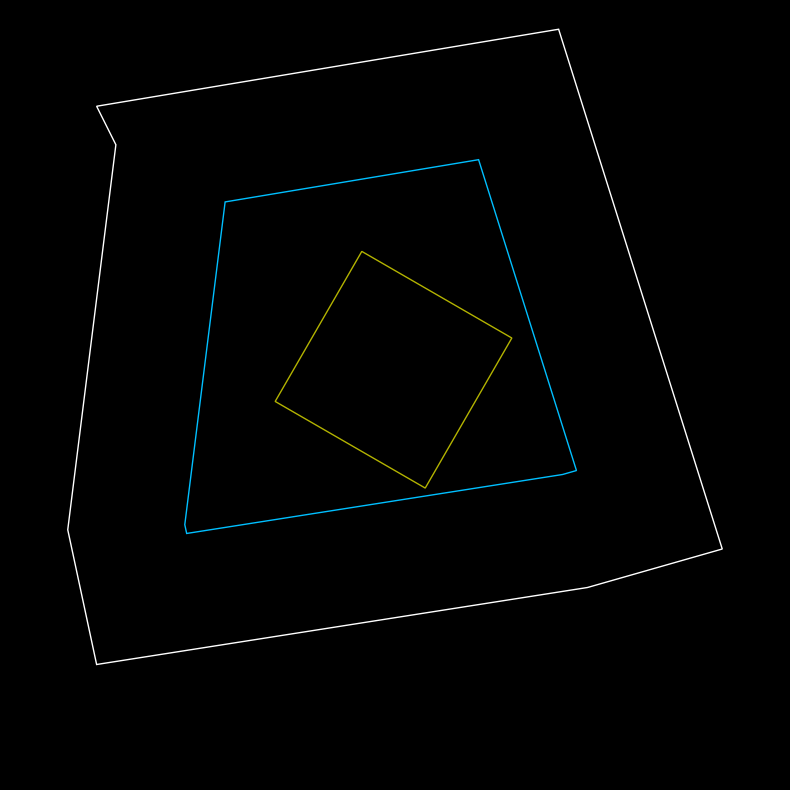

Изображение успешно сохранено в ./DB_TEST/png/ready_plan_1.png
(18, 18)


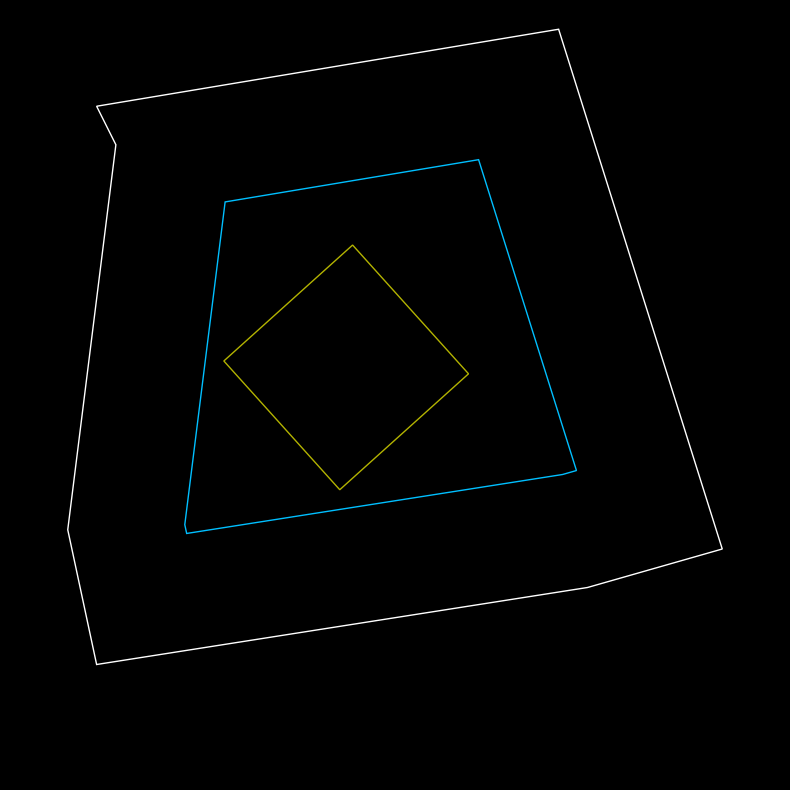

Изображение успешно сохранено в ./DB_TEST/png/ready_plan_2.png
(26, 16)


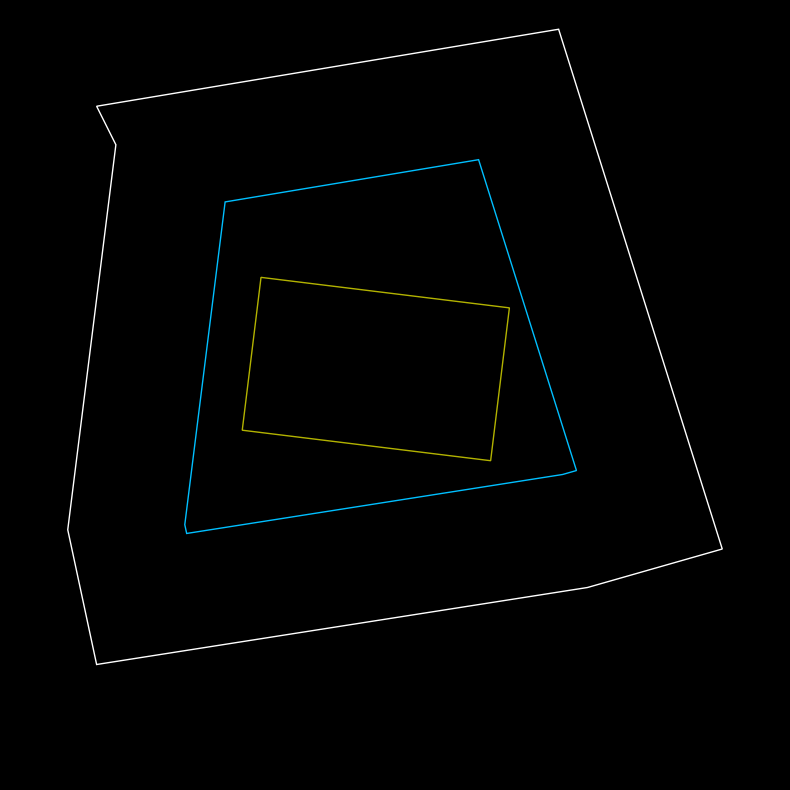

Изображение успешно сохранено в ./DB_TEST/png/ready_plan_3.png
(26, 16)


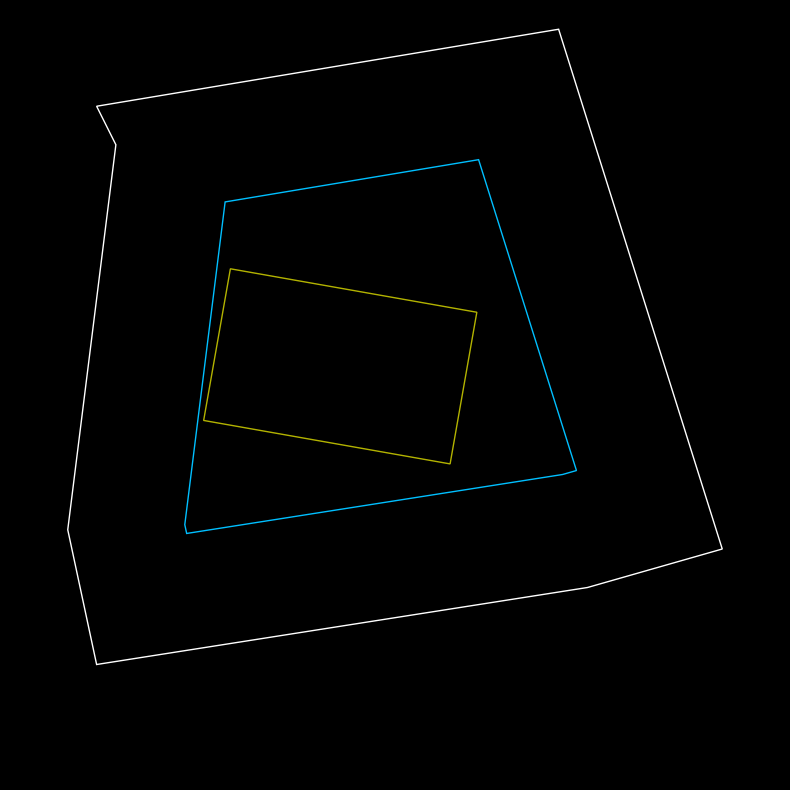

Изображение успешно сохранено в ./DB_TEST/png/ready_plan_4.png
(28, 16)


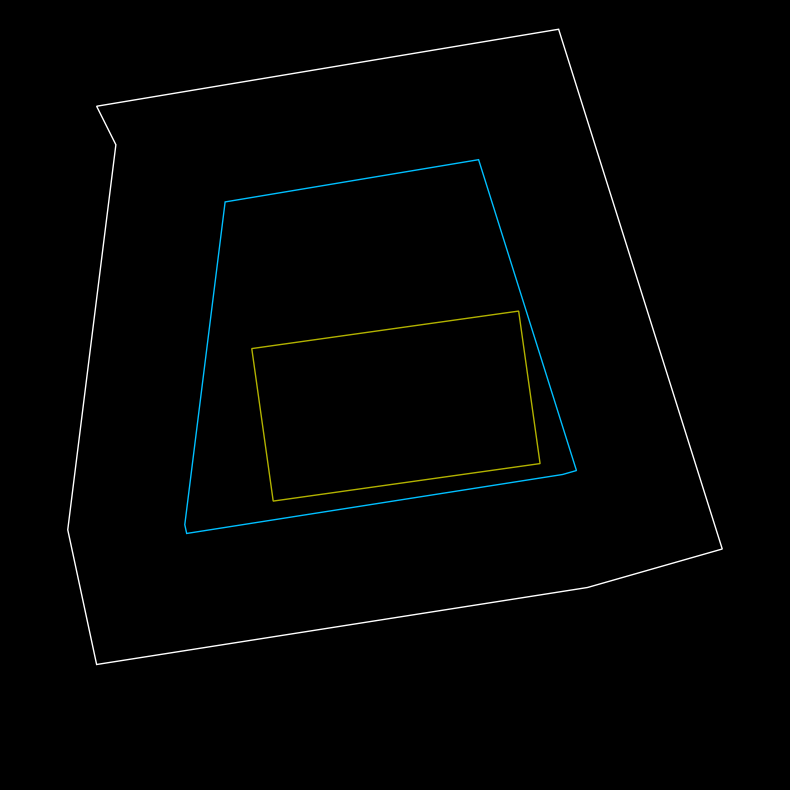

Изображение успешно сохранено в ./DB_TEST/png/ready_plan_5.png
(26, 18)


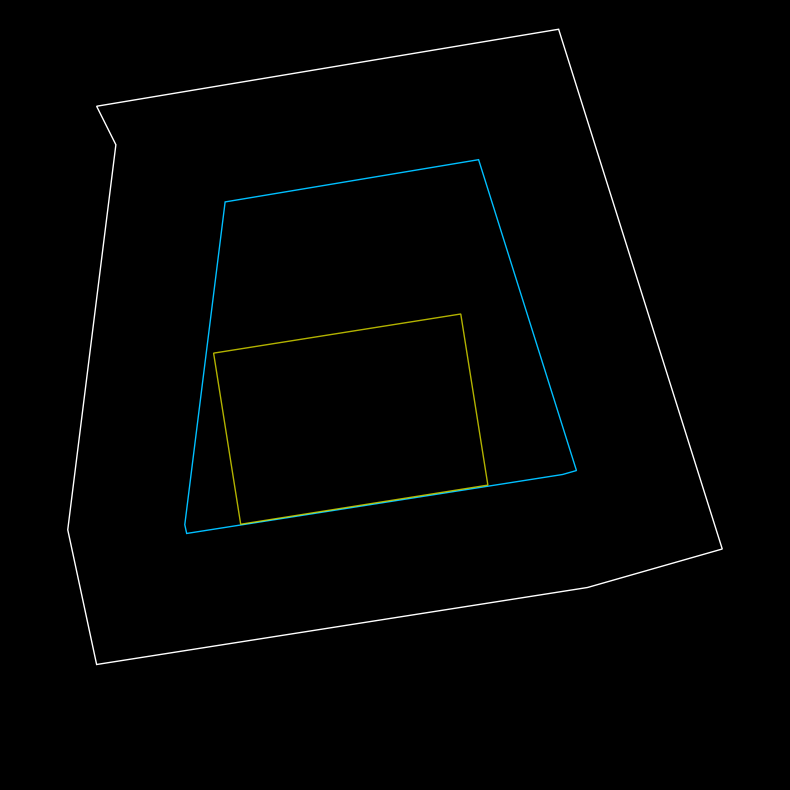

Изображение успешно сохранено в ./DB_TEST/png/ready_plan_6.png
Не удалось разместить здание заданного размера в зоне отступа - изображение не создано
L-28x16+18x18


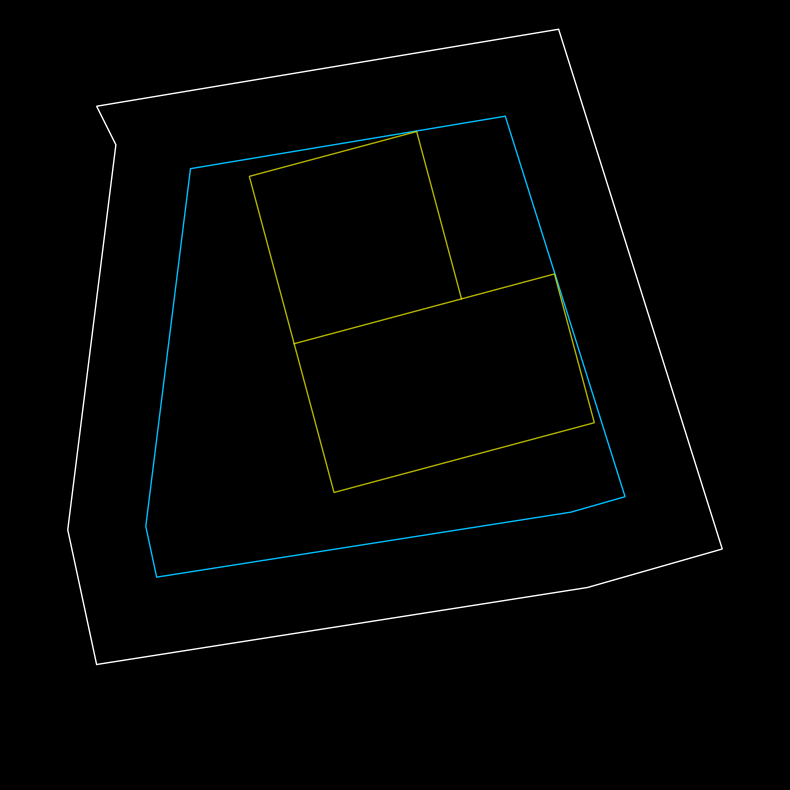

Изображение успешно сохранено в ./DB_TEST/png/ready_plan_8.png
L-26x16+18x18


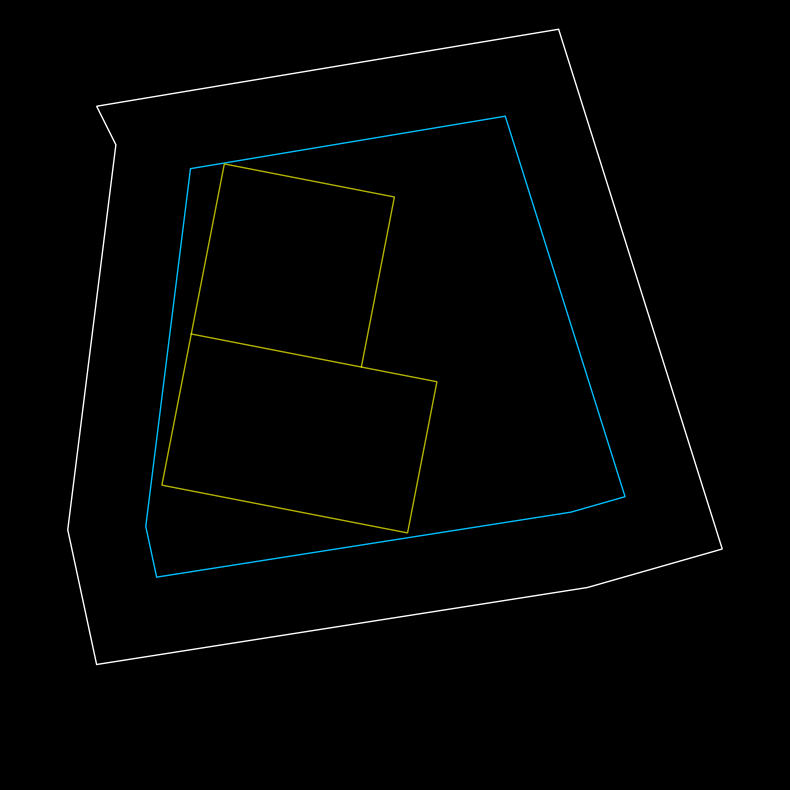

Изображение успешно сохранено в ./DB_TEST/png/ready_plan_9.png
Не удалось разместить здание заданного размера в зоне отступа - изображение не создано


In [113]:
counter = 1
for building_type, setback in zip(building_types, setbacks):
    visualization(polygon_coords, setback, building_type, counter)
    counter += 1